## Expected Free Energy for oscillator with nonlinear observations

Wouter Kouw, last update: 20-11-2022

### System

Consider a [harmonic oscillator](https://en.wikipedia.org/wiki/Harmonic_oscillator#Driven_harmonic_oscillators) with displacement $x(t)$, driving force $u(t)$ and noise $w(t)$. The continuous-time dynamics of the system are:

$$\begin{align*}
m \frac{d^2 x(t)}{dt^2} =&\ - c \frac{d x(t)}{dt} - k x(t) + u(t) + w(t)\, ,
\end{align*}$$
where 
$$
m     = \text{mass} \, , \quad
c     = \text{damping} \, , \quad
k     = \text{spring stiffness} 
$$
constitute the physical parameters. 

#### Multivariate first-order system

We will first adopt a more concise notation and then divide by the leading coefficient:

$$ x'' = \frac{-c}{m} x' + \frac{-k}{m} x + \frac{1}{m} u + \frac{1}{m} w \, .$$

With the variable substitution $z = [x \ x']$, I cast the above system into a multi-variate first-order form:

$$ \begin{bmatrix} x' \\ x'' \end{bmatrix} = \begin{bmatrix} 0 & 1 \\ \frac{-k}{m} & \frac{-c}{m} \end{bmatrix} \begin{bmatrix} x \\ x' \end{bmatrix} + \begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix} u + \begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix} w\, .$$

#### Discretization

For the Van Loan discretization of the Wiener process, I first consider a first-order approximation of the matrix exponential of the transition matrix: 

$$F(t) = I + \begin{bmatrix} 0 & 1 \\ \frac{-k}{m} & \frac{-c}{m} \end{bmatrix} t \, .$$

Then, I will consider the continuous-time covariance matrix of the noise in multi-variate form:

$$\mathbb{V}[\begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix} w] = \begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix} \mathbb{V}[w] \begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix}^{\top} = \begin{bmatrix} 0 & 0 \\ 0 & \frac{\sigma^2}{m^2} \end{bmatrix} \triangleq V \, .$$

Now, I can integrate the evolution of the covariance matrix from over the duration of a time-step. If all time-steps are equally long, e.g., of size $\Delta t$, then

$$Q = \int_0^{\Delta t} F(t) V F(t)^{\top} dt = \frac{\sigma^2}{m^2} \begin{bmatrix} \frac{\Delta t^3}{3} & \frac{-c}{m}\frac{\Delta t^3}{3} + \frac{\Delta t^2}{2} \\ \frac{-c}{m}\frac{\Delta t^3}{3} + \frac{\Delta t^2}{2} & \frac{c^2}{m^2}\frac{\Delta t^3}{3} + \frac{\Delta t^2}{2} + \Delta t \end{bmatrix} \, ,$$

where $\sigma^2 = \mathbb{V}[w]$. A forward Euler discretization for the state transition yields:

$$\begin{align*} 
\left( \begin{bmatrix} x_{k+1} \\ x'_{k+1} \end{bmatrix} - \begin{bmatrix} x_{k} \\ x'_{k} \end{bmatrix} \right) / \Delta t =&\ \begin{bmatrix} 0 & 1 \\ \frac{-k}{m} & \frac{-c}{m} \end{bmatrix} \begin{bmatrix} x_k \\ x'_k \end{bmatrix} + \begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix} u_k \, ,
\end{align*}$$

So, we end up with:

$$\begin{align*}
z_k =&\ \underbrace{\begin{bmatrix} 1 & \Delta t \\ \frac{-k}{m} \Delta t & \frac{-c}{m} \Delta t + 1 \end{bmatrix}}_{A} z_{k-1} + \underbrace{\begin{bmatrix} 0 \\ \frac{1}{m} \Delta t \end{bmatrix}}_{B} u_k + q_k \quad \text{where} \quad q_k \sim \mathcal{N}(0,Q) \, .
\end{align*}$$

We have noisy observations of a nonlinear function $g$ of the displacement, 

$$ y_k = g(z_k) + r_k \quad \text{where} \quad r_k \sim \mathcal{N}(0, R) \, .$$

This gives an overall probabibilistic state-space model of the form:

$$\begin{align}
p(z_0) &= \mathcal{N}(z_0 \mid m_0, S_0) \\
p(z_k \mid z_{k-1}, u_k) &= \mathcal{N}(z_k \mid Az_{k-1} + Bu_k, Q) \\
p(y_k \mid z_k) &= \mathcal{N}(y_k \mid g(z_k), R) \, .
\end{align}$$

We can simulate the behaviour of this system as follows:

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/syndr/Wouter/Onderzoek/Projecten/tue/efe-planning/ECC2023-efe4ukf`


In [2]:
using Optim
using ForwardDiff
using ProgressMeter
using LinearAlgebra
using ControlSystems
using Distributions
using Plots
default(label="", grid=false, linewidth=3, markersize=3, margin=10Plots.pt)

In [3]:
# System parameters
mass = 3.0
friction = 0.9
stiffness = 2.0

# Substituted parameters
θ1_true = -stiffness/mass
θ2_true = -friction/mass
θ3_true = 1/mass

# Temporal variables
Δt = 0.1
len_time = 200
time = range(0, step=Δt, length=len_time)

# Matrices
A = [1 Δt; θ1_true*Δt θ2_true*Δt+1]
B = [0, θ3_true*Δt]
C = [1, 0]

# Inverse functions for parameters
g1(y,x,u, θ2, θ3) = (y[2] - (Δt*θ2+1)*x[2] - Δt*θ3*u)/(Δt*x[1])
# g2(y,x,u, θ1, θ3) = 
# g3(y,x,u, θ1, θ2) = 
    
# Measurement noise
R = 1e-3;

In [4]:
function update(z_kmin1, u_k)
   "Update environment" 
    
    # State transition
    z_k = A*z_kmin1 + B*u_k
    
    # Emit noisy observation
    y_k = rand(Normal(dot(C,z_k), sqrt(R)))
    
    return y_k, z_k
end;

In [5]:
# Control
u = [sin.(time[1:Int64(round(len_time/4))] .* 2/π); 
     zeros(len_time-Int64(round(len_time/4)))]

# Setpoint (desired observation)
z_star = [-0.8, 0.0]
y_star = dot(C,z_star)

-0.8

In [6]:
# Initial state
z_0 = [0.0, 0.0]

# Preallocate
z = zeros(2,len_time)
y = zeros(len_time)

# Start recursion
z_kmin1 = z_0
for k in 1:len_time
    
    # Update system
    y[k], z[:,k] = update(z_kmin1, u[k])
    
    # Update recursion
    z_kmin1 = z[:,k]
    
end

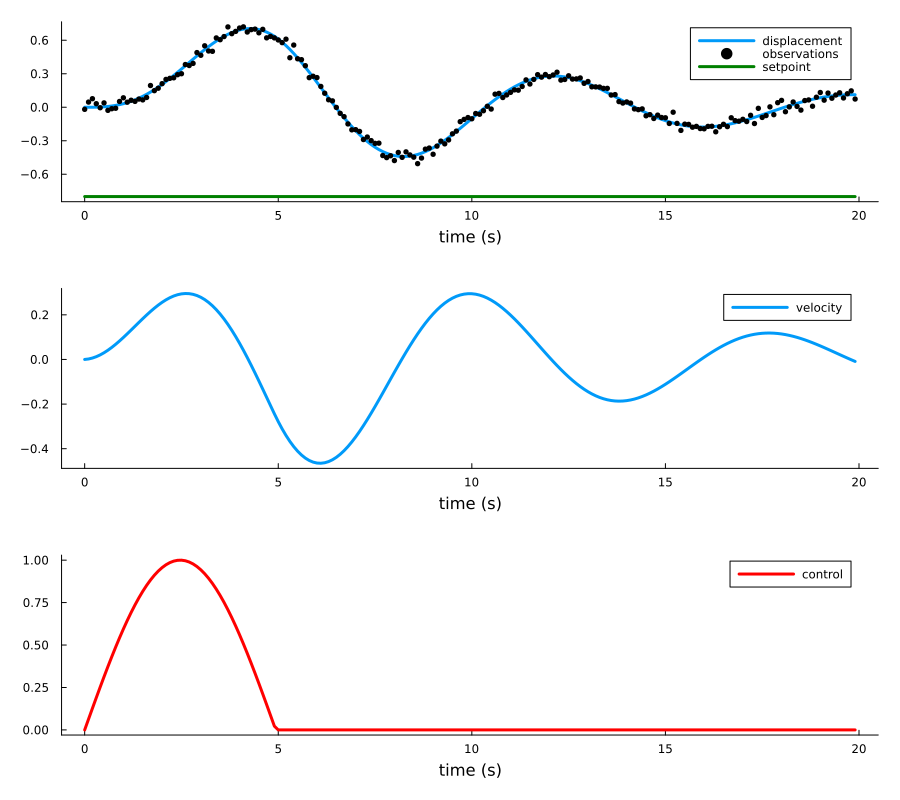

In [7]:
p1 = plot(time, z[1,:], xlabel="time (s)", label="displacement")
scatter!(time, y, color="black", label="observations")
plot!(time, y_star*ones(len_time), color="green", label="setpoint")
p2 = plot(time, z[2,:], xlabel="time (s)", label="velocity")
p3 = plot(time, u, color="red", xlabel="time (s)", label="control")
plot(p1, p2, p3, layout=(3,1), size=(900,800))

## Expected Free Energy

From the agent's viewpoint, the evolution of these future variables are constrained by its generative model, rolled out into the future:
$$\begin{aligned}
p(y,z,u) &= \underbrace{q(z_{k})}_{\substack{\text{current}\\ \text{state}}} \cdot \underbrace{\prod_{t=k+1}^{k+T} p(y_t|z_t) \cdot p(z_t | z_{t-1}, u_t) p(u_t)}_{\text{generative model roll-out to future}} \, ,
\end{aligned}$$

where $y = (y_t, \dots, y_T)$, $z = (z_{t-1}, \dots, z_T)$ and $u = (u_t, \dots, u_T)$. 

Consider the varational free energy functional for estimating posterior beliefs $q(z,u)$ over future states and control signals, with an expectation over future observations $q(y \mid z)$: 

$$\begin{aligned}
H[q] &= \overbrace{\iint q(y \mid z)}^{\text{marginalize }y} \bigg( \overbrace{\int q(z,u) \log \frac{q(z,u)}{p(y,z,u)} }^{\text{variational free energy}}\bigg) \mathrm{d}u \, \mathrm{d}y \, \mathrm{d}z \\
&= \int q(y,z,u) \log \frac{q(z,u)}{p(y,z,u)} \mathrm{d}u \, \mathrm{d}y \, \mathrm{d}z \\
&= \int q(y,z|u) q(u) \log \frac{q(z|u) q(u)}{p(y,z|u) p(u)} \mathrm{d}u \, \mathrm{d}y \, \mathrm{d}z \\
&= \int q(u) \bigg(\sum_{y,z} q(y,z|u) \log \frac{q(s|u) q(u)}{p(y,z|u) p(u)}\bigg) \mathrm{d}u \, \mathrm{d}y \, \mathrm{d}z \\
&= \int q(u) \bigg( \log q(u) + \log \frac{1}{p(u)}+ \underbrace{q(y,z|u) \log \frac{q(z|u)}{p(y,z|u)}}_{G(u)}\bigg) \mathrm{d}u \, \mathrm{d}y \, \mathrm{d}z \\
&= \int q(u) \log \frac{q(u)}{p(u)\exp\left(- G(u)\right) } \mathrm{d}u  \, .
\end{aligned}$$

We can recognize a KL-divergence between $q(u)$ and the function $p(u)\exp\left(- G(u)\right)$, which will be minimal when $q(u) = p(u)\exp\left(- G(u)\right)$. The $G$ function is known as the _Expected Free Energy_. Let's look at it in detail for a future observation $t$,

$$ G(u_t) = \iint q(y_t, z_t \mid u_t) \log \frac{q(z_t \mid u_t)}{p(y_t, z_t \mid u_t)} \mathrm{d}y_t \, \mathrm{d}z_t \, ,$$

where 

$$\begin{aligned}
% q(y_t \mid z_t) &= \mathcal{N}(y_t \mid Cz_t, R) \\
% q(z_t \mid u_t) &= \int p(z_t \mid z_{t-1}, u_t) q(z_{t-1}) \mathrm{d}z_{t-1} \\
% &= \mathcal{N}(z_t \mid A m_{t-1} + Bu_t, AS_{t-1}A^{\top} + Q) \\
p(y_t, z_t \mid u_t) &= \int p(y_t \mid z_t) p(z_t \mid z_{t-1}, u_t) q(z_{t-1}) \mathrm{d}z_{t-1} \\
&= \mathcal{N}(\begin{bmatrix} y_t \\ z_t \end{bmatrix} \mid \begin{bmatrix} C(A m_{t-1} + Bu_t) \\ A m_{t-1} + Bu_t \end{bmatrix}, \begin{bmatrix} C(AS_{t-1}A^{\top} + Q) C^{\top} + R & C(AS_{t-1}A^{\top} + Q) \\ (AS_{t-1}A^{\top} + Q)C^{\top} & AS_{t-1}A^{\top} + Q \end{bmatrix}) \, ,
\end{aligned}$$

with the approximate posterior for the previous state $q(z_{t-1}) = \mathcal{N}(z_{t-1} \mid m_{t-1}, S_{t-1})$. The distribution $q(z_t \mid u_t)$ is constructed from the state transition:

$$q(z_t \mid u_t) = \int p(z_t \mid z_{t-1}, u_t) q(z_{t-1}) \mathrm{d}z_{t-1} = \mathcal{N}(z_t \mid A m_{t-1} + Bu_t, AS_{t-1}A^{\top} + Q) \, ,$$

and $q(y_t, z_t \mid u) = p(y_t \mid z_t) q(z_t \mid u_t)$ which is equivalent to $p(y_t, z_t \mid u_t)$ in this case. Note that - during planning and in linear Gaussian models - we can drive the KL-divergence between the approximate posteriors $q$ and the true posteriors $p$ to 0, thus allowing us to swap $q$ for $p$.

We will decompose this EFE function into ambiguity plus risk terms (see [lecture slides](https://nbviewer.org/github/bertdv/BMLIP/blob/master/lessons/notebooks/Intelligent-Agents-and-Active-Inference.ipynb) for more detail). To do so, we will decompose $p(y_t,z_t \mid u_t)$ into $p^\prime(y_t)p(z_t|y_t,u_t)$ where $p\prime(y_t)$ is a distribution over the goal state, a.k.a. a _goal prior_; $p^\prime(y) = \mathcal{N}(y \mid m_*, s_*)$. The derivation goes as follows:

$$\begin{aligned}
G(u_t) &= \int  q(y_t,z_t|u_t) \log \frac{q(z_t|u_t)}{p^\prime(y_t)p(z_t|y_t,u_t)} \, \mathrm{d}y_t \, \mathrm{d}z_t \\
&= \int  q(y_t, z_t \mid u_t) \log \frac{q(z_t \mid u_t)}{p^\prime(y_t)} \frac{1}{p(z_t \mid y_t, u_t)} \, \mathrm{d}y_t \, \mathrm{d}z_t \\
&= \int  q(y_t, z_t \mid u_t) \log \frac{q(z_t \mid u_t)}{p^\prime(y_t)} \frac{p(y_t \mid u_t)}{p(y_t \mid z_t)p(z_t \mid u_t)} \, \mathrm{d}y_t \, \mathrm{d}z_t \\
&= \int  q(y_t,z_t|u_t) \log \frac{q(z_t|u_t)}{p(y_t|z_t)p(z_t|u_t)} \frac{p(y_t|u_t)}{p^\prime(y_t)} \, \mathrm{d}y_t \, \mathrm{d}z_t \\
&= \int  q(y_t,z_t|u_t) \log \frac{q(z_t|u_t)}{p(y_t|z_t)p(z_t|u_t)} \, \mathrm{d}z_t \, \mathrm{d}y_t + \int q(y_t,z_t|u_t) \log \frac{p(y_t|u_t)}{p^\prime(y_t)} \, \mathrm{d}y_t \, \mathrm{d}z_t \\
&= \int  p(z_t|u_t) p(y_t|z_t) \log \frac{1}{p(y_t|z_t)} \, \mathrm{d}z_t \, \mathrm{d}y_t + \int p(z|u) p(y|z) \log \frac{p(y_t|u_t)}{p^\prime(y_t)} \, \mathrm{d}z_t \, \mathrm{d}y_t \\
&= \underbrace{\int  p(z_t|u_t) \int p(y_t|z_t) \log \frac{1}{p(y_t|z_t)} \, \mathrm{d}z_t \, \mathrm{d}y_t}_{\text{ambiguity}} + \underbrace{\int p(y_t|u_t) \log \frac{p(y_t|u_t)}{p^\prime(y_t)} \, \mathrm{d}y_t}_{\text{risk}} \ \, ,
\end{aligned}$$

Ambiguity is an expectation over an entropy, which - in the case of a Gaussian likelihood - is actually independent of the state,

$$\int p(y_t|z_t) \log p(y_t|z_t) \mathrm{d}y_t = \frac{1}{2}\big(\log 2\pi R - 1\big) \, ,$$

so the expectation over $p(z_t|u_t)$ doesn't even apply. As you may have noticed, the control $u_t$ doesn't affect ambiguity which means there is no information-seeking behaviour in linear Gaussian state-space models.

The risk term is a KL-divergence between the Gaussian,

$$\begin{aligned}
    p(y_t|u_t) &= \int p(y_t, z_t \mid u_t) \, \mathrm{d}z_t  \\
    &= \int \mathcal{N}(\begin{bmatrix} y_t \\ z_t \end{bmatrix} \mid \begin{bmatrix} C(A m_{t-1} + Bu_t) \\ A m_{t-1} + Bu_t \end{bmatrix}, \begin{bmatrix} C(AS_{t-1}A^{\top} + Q) C^{\top} + R & C(AS_{t-1}A^{\top} + Q) \\ (AS_{t-1}A^{\top} + Q)C^{\top} & AS_{t-1}A^{\top} + Q \end{bmatrix}) \, \mathrm{d}z_t \\
    &= \mathcal{N}(y_t \mid C(A m_{t-1} + Bu_t) , C(AS_{t-1}A^{\top} + Q) C^{\top} + R) \, ,
    \end{aligned}$$
    
and the goal prior $p^\prime(y_t)$. The formula for the KL-divergence between two Gaussians is (see [wiki](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Multivariate_normal_distributions)):

$$\begin{aligned}
D_{\text{KL}}( \mathcal{N}(x \mid m_1, \sigma_1) || \mathcal{N}(x \mid m_2, \sigma_2) ) = \frac{1}{2} \Big[\log\frac{|\Sigma_2|}{|\Sigma_1|} - d + \text{tr}(\Sigma_2^{-1}\Sigma_1) + (\mu_2 - \mu_1)^{\top}\Sigma_2^{-1}(\mu_2 - \mu_1) \Big] \, .
\end{aligned}$$

For our distribution, this becomes:

$$\int p(y_t|u_t) \log \frac{p(y_t|u_t)}{p^\prime(y_t)} \, \mathrm{d}y_t = \frac{1}{2} \Big[\log\frac{s_*}{|C(AS_{t-1}A^{\top} + Q) C^{\top} + R|} - 1 + \text{tr}(\frac{(C(AS_{t-1}A^{\top} + Q) C^{\top} + R)}{s_*}) + \frac{\big(m_* - (C(A m_{t-1} + Bu_t))\big)^2}{s_*}) \Big]$$


The decomposition is the same for any future state $t$. We may thus unroll the policy as $G(u) = \sum_{t=k+1}^{TT} G(u_t)$.

---

The above equations can be written down to form an objective function.

In [8]:
function EFE(u::AbstractVector,
             params::Vector{Float64},
             state::Tuple{Vector{Float64}, Matrix{Float64}}, 
             goal::Tuple{Float64,Float64}; 
             s_u::Float64=1.0,
             time_horizon::Int64=1)
    "Expected Free Energy"
    
    # Matrices
    A = [1 Δt; params[1]*Δt params[2]*Δt+1]
    B = [0, params[3]*Δt]
    
    # Unpack goal state
    m_star, S_star = goal
    iS = inv(S_star)
    
    # Unpack parameters of current state
    m_tmin1, S_tmin1 = state
    
    # Start cumulative sum
    cEFE = 0.0
    for t in 1:time_horizon
        
        # State transition p(z_t | u_t)
        m_t = A*m_tmin1 + B*u[t]
        S_t = A*S_tmin1*A'

        # Predicted observation 
        m_pred = dot(C,m_t)
        S_pred = dot(C'*S_t,C) + R
        
        # First term of EFE
        ambiguity = 0.5(log(2π) + log(R) - 1)

        # Risk
        diff_m = (m_pred - m_star)
        iS_star = inv(S_star)
        risk = 0.5(log(det(S_star)/det(S_pred)) + 1 + diff_m'*iS_star*diff_m + tr(iS_star*S_pred))
        
        # Prior term
        prior_u = 1/(s_u)*u[t]^2
        
        # Cumulate EFE
        cEFE += ambiguity + risk + prior_u
        
        # Update state recursion
        m_tmin1 = m_t
        S_tmin1 = S_t
                
    end
    return cEFE
end

EFE (generic function with 1 method)

We can use the Optim.jl library to auto-differentiate EFE and minimize it every time step.

In [9]:
len_trial = 100
time = range(0, step=Δt, length=len_trial)

# Time horizon
len_horizon = 5;

In [10]:
# Distribution around goal state
goal_state = (y_star, 1e-3)

# Limits of controller
u_lims = (-100.0, 100.0)

# Num samples for particle filter
n_samples = 1000

# Preallocate
z_est = (zeros(2,len_trial), zeros(2,2,len_trial))
θ_est = (zeros(len_trial), zeros(len_trial))
z_sim = zeros(2,len_trial)
y_sim = zeros(len_trial)
u_sim = zeros(len_trial)

# Initial belief
m_0 = zeros(2)
S_0 = diagm(ones(2))

# Parameter priors
μ_0 = 0.0
Σ_0 = 1.0

# Actual initial state
z_sim[:,1] = z_0

# Start recursion
m_kmin1 = m_0
S_kmin1 = S_0
μ_kmin1 = μ_0
Σ_kmin1 = Σ_0

@showprogress for k in 2:len_trial
    
    "Interact with environment"
    
    # Update system with selected control
    y_sim[k], z_sim[:,k] = update(z_sim[:,k-1], u_sim[k-1])
   
    "State estimation"
    
    # Update matrices
    A = [1 Δt; μ_kmin1*Δt θ2_true*Δt+1]
    B = [0, θ3_true*Δt]
    
    # Prediction step
    m_k_pred = A*m_kmin1 + B*u_sim[k-1]
    S_k_pred = A*S_kmin1*A'
    
    # Update step
    K = S_k_pred*(C*inv(dot(C'*S_k_pred,C) + R))
    m_k = m_k_pred + K*(y_sim[k] - dot(C,m_k_pred))
    S_k = S_k_pred - K*(dot(C'*S_k_pred,C) + R)*K'
    
    # Store state estimates
    z_est[1][:,k] = m_k
    z_est[2][:,:,k] = S_k
    
    "Parameter estimation"
    
    # Sample from previous state
    sx_ = rand(MvNormal(m_kmin1, Hermitian(S_kmin1)), n_samples)
    # sy_ = rand(MvNormal(m_k,     S_k),     n_samples)
    sy_ = zeros(2,n_samples)
    
    ss = [g1(sy_[:,i], sx_[:,i], u_sim[k-1], θ2_true, θ3_true) for i = 1:n_samples]
    smm = mean(ss)
    smS = var(ss)
    
    # Marginal update as collision of messages
    Σ_k = inv(inv(Σ_kmin1) + inv(smS))
    μ_k = Σ_k*(inv(Σ_kmin1)*μ_kmin1 + inv(smS)*smm)
    
    # Store parameter estimates
    θ_est[1][k] = μ_k
    θ_est[2][k] = Σ_k
    
    "Planning"
    
    # Single-argument objective
    G(u::AbstractVector) = EFE(u, [μ_kmin1, θ2_true, θ3_true], (m_k,S_k), goal_state, s_u=1e6, time_horizon=len_horizon)
    
    # Call minimizer using constrained L-BFGS procedure
    results = Optim.optimize(G, u_lims[1], u_lims[2], zeros(len_horizon), Fminbox(LBFGS()); autodiff=:forward)
    
    # Extract minimizing control
    u_sim[k] = Optim.minimizer(results)[1]
   
    # Update recursion
    m_kmin1 = m_k
    S_kmin1 = S_k
    μ_kmin1 = μ_k
    Σ_kmin1 = Σ_k
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


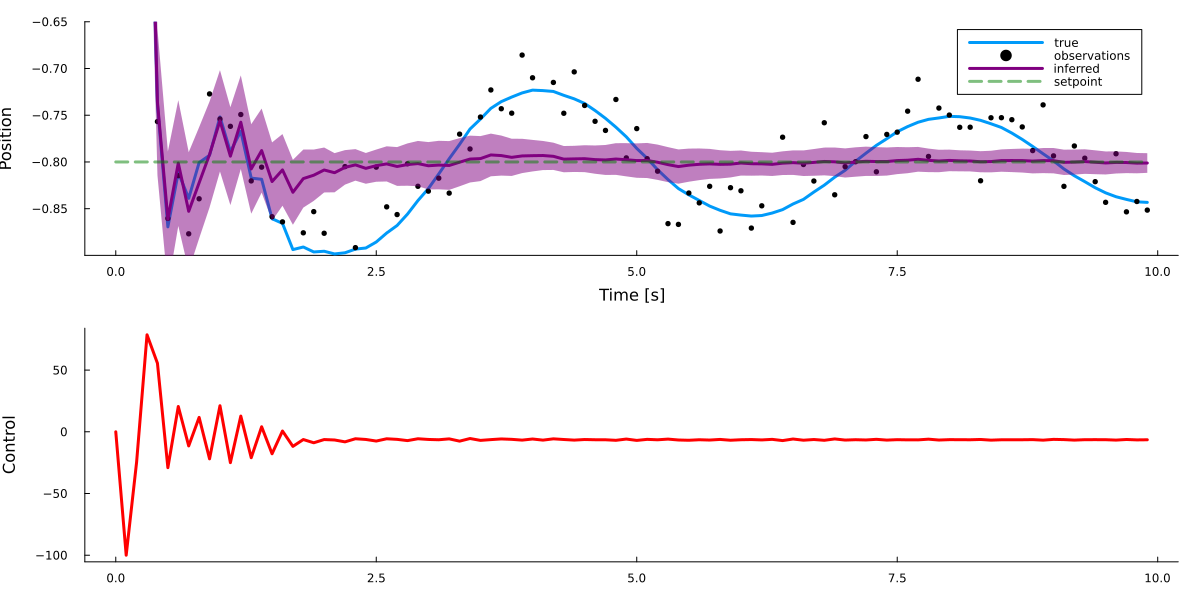

In [11]:
p301 = plot(time, z_sim[1,:], label="true", ylabel="Position", xlabel="Time [s]")
scatter!(time, y_sim, label="observations", color="black", ylims=[-0.9, -.65])
plot!(time, z_est[1][1,:], ribbon=3sqrt.(z_est[2][1,1,:]), label="inferred", color="purple")
plot!(time, y_star*ones(len_trial), color="green", alpha=0.5, linestyle=:dash, label="setpoint")
p302 = plot(time, u_sim, color="red", ylabel="Control")
plot(p301, p302, layout=(2,1), size=(1200,600))

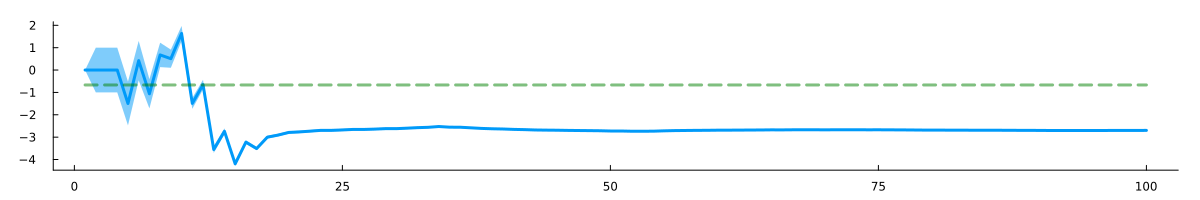

In [12]:
plot(θ_est[1], ribbon=sqrt.(θ_est[2]))
plot!(θ1_true*ones(len_trial), color="green", linestyle=:dash, alpha=0.5, size=(1200,200))

### Visualization

Let's visualize the planned trajectory.

In [13]:
len_trial = 100
time = range(0, step=Δt, length=len_trial)

# Time horizon
len_horizon = 5;

In [14]:
function planned_trajectory(policy, current_state, params)
    "Generate future states and observations"
    
    # Matrices
    A = [1 Δt; params[1]*Δt params[2]*Δt+1]
    B = [0, params[3]*Δt]
    
    # Extract time horizon
    time_horizon = length(policy)
    
    # Unpack parameters of current state
    m_tmin1, S_tmin1 = current_state
    
    # Track predicted observations
    z_m = zeros(2,time_horizon)
    z_S = zeros(2,2,time_horizon)
    y_m = zeros(time_horizon)
    y_v = zeros(time_horizon)
    
    for t in 1:time_horizon
        
        # State transition
        z_m[:,t] = A*m_tmin1 + B*policy[t]
        z_S[:,:,t] = A*S_tmin1*A'
        
        # Predicted observation 
        y_m[t] = dot(C,z_m[:,t])
        y_v[t] = dot(C'*z_S[:,:,t],C) + R
        
        # Update previous state
        m_tmin1 = z_m[:,t]
        S_tmin1 = z_S[:,:,t]
        
    end
    return z_m, z_S, y_m, y_v
end

planned_trajectory (generic function with 1 method)

In [15]:
# Distribution around goal state
goal_state = (y_star, 1e-3)

# Limits of controller
u_lims = (-100.0, 100.0)

# Num samples for particle filter
n_samples = 1000

# Preallocate
θ_est = (zeros(len_trial), zeros(len_trial))
z_est = (zeros(2,len_trial), zeros(2,2,len_trial))
z_pln = (zeros(len_trial, 2,len_horizon), zeros(len_trial, 2,2,len_horizon))
y_pln = (zeros(len_trial, len_horizon), zeros(len_trial,len_horizon))
z_sim = zeros(2,len_trial)
y_sim = zeros(len_trial)
u_sim = zeros(len_trial)
cA    = zeros(len_trial, len_horizon)
cR    = zeros(len_trial, len_horizon)

# Initial belief
m_0 = zeros(2)
S_0 = diagm(ones(2))

# Parameter priors
μ_0 = 0.0
Σ_0 = 1.0

# Actual initial state
z_sim[:,1] = z_0

# Start recursion
m_kmin1 = m_0
S_kmin1 = S_0
μ_kmin1 = μ_0
Σ_kmin1 = Σ_0

@showprogress for k in 2:len_trial
    
    "Interact with environment"
    
    # Update system with selected control
    y_sim[k], z_sim[:,k] = update(z_sim[:,k-1], u_sim[k-1])
   
    "State estimation"
    
    # Update matrices
    A = [1 Δt; μ_kmin1*Δt θ2_true*Δt+1]
    B = [0, θ3_true*Δt]
    
    # Prediction step
    m_k_pred = A*m_kmin1 + B*u_sim[k-1]
    S_k_pred = A*S_kmin1*A'
    
    # Update step
    K = S_k_pred*(C*inv(dot(C'*S_k_pred,C) + R))
    m_k = m_k_pred + K*(y_sim[k] - dot(C,m_k_pred))
    S_k = S_k_pred - K*(dot(C'*S_k_pred,C) + R)*K'
    
    # Store state estimates
    z_est[1][:,k] = m_k
    z_est[2][:,:,k] = S_k
    
    "Parameter estimation"
    
    # Sample from previous state
    sx_ = rand(MvNormal(m_kmin1, Hermitian(S_kmin1)), n_samples)
    # sy_ = rand(MvNormal(m_k,     S_k),     n_samples)
    sy_ = zeros(2,n_samples)
    
    ss = [g1(sy_[:,i], sx_[:,i], u_sim[k-1], θ2_true, θ3_true) for i = 1:n_samples]
    smm = mean(ss)
    smS = var(ss)
    
    # Marginal update as collision of messages
    Σ_k = inv(inv(Σ_kmin1) + inv(smS))
    μ_k = Σ_k*(inv(Σ_kmin1)*μ_kmin1 + inv(smS)*smm)
    
    # Store parameter estimates
    θ_est[1][k] = μ_k
    θ_est[2][k] = Σ_k
    
    "Planning"
    
    params = [μ_kmin1, θ2_true, θ3_true]
    
    # Single-argument objective
    G(u::AbstractVector) = EFE(u, params, (m_k,S_k), goal_state, s_u=1e6, time_horizon=len_horizon)
    
    # Call minimizer using constrained L-BFGS procedure
    results = Optim.optimize(G, u_lims[1], u_lims[2], zeros(len_horizon), Fminbox(LBFGS()); autodiff=:forward)
    policy = Optim.minimizer(results)
    
    # Planning
    z_pln[1][k,:,:], z_pln[2][k,:,:,:], y_pln[1][k,:], y_pln[2][k,:] = planned_trajectory(policy, (m_k,S_k), params)
    
    # Execute first planned action only
    u_sim[k] = policy[1]
   
    # Update recursion
    m_kmin1 = m_k
    S_kmin1 = S_k
    μ_kmin1 = μ_k
    Σ_kmin1 = Σ_k
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


┌ Info: Saved animation to /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-planning/ECC2023-efe4ukf/figures/planning.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/zzg7i/src/animation.jl:149


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-planning/ECC2023-efe4ukf/figures/planning.gif")
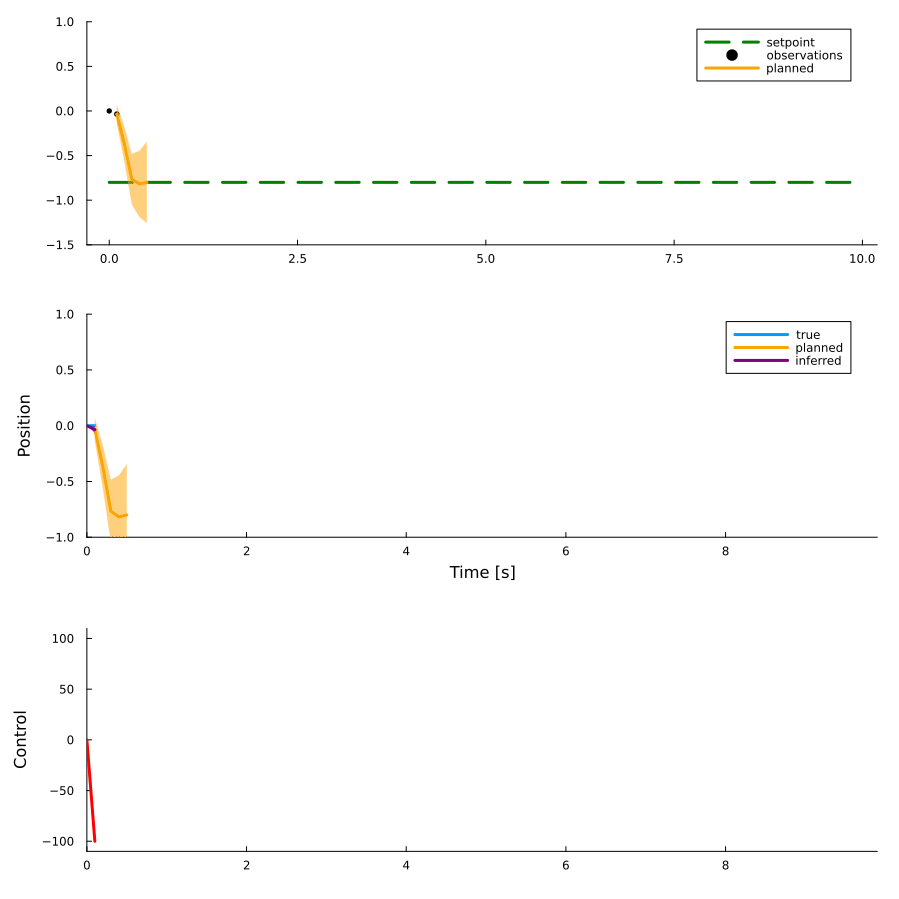

In [16]:
anim = @animate for k = 2:(len_trial-len_horizon)
    
    p201 = plot(time, y_star*ones(len_trial), color="green", linestyle=:dash, label="setpoint", ylims=[-1.5, 1.0])
    scatter!(time[1:k], y_sim[1:k], color="black", label="observations")
    plot!(time[k:k+len_horizon-1], y_pln[1][k,:], ribbon=sqrt.(y_pln[2][k,:]), label="planned", color="orange")
    
    p202 = plot(time[1:k], z_sim[1,1:k], xlims=[time[1], time[end]], label="true", ylabel="Position", xlabel="Time [s]")
    plot!(time[k:k+len_horizon-1], z_pln[1][k,1,:], ribbon=sqrt.(z_pln[2][k,1,1,:]), label="planned", color="orange")
    plot!(time[1:k], z_est[1][1,1:k], ribbon=sqrt.(z_est[2][1,1,1:k]), label="inferred", color="purple", ylims=[-1,1])
    
    p203 = plot(time[1:k], u_sim[1:k], xlims=[time[1], time[end]], color="red", ylabel="Control", ylims=u_lims.*1.1)
    
    plot(p201, p202, p203, layout=(3,1), size=(900,900))
end
gif(anim, "figures/planning.gif")

### Analysis

In [17]:
function EFE_analysis(u::AbstractVector, 
                      params::Vector{Float64},
                      state::Tuple{Vector{Float64}, Matrix{Float64}}, 
                      goal::Tuple{Float64,Float64};
                      Q::AbstractMatrix=zeros(2,2),
                      time_horizon::Int64=1)
    
    # Matrices
    A = [1 Δt; params[1]*Δt params[2]*Δt+1]
    B = [0, params[3]*Δt]
    
    # Unpack goal state
    m_star, S_star = goal
    iS = inv(S_star)
    
    # Unpack parameters of current state
    m_tmin1, S_tmin1 = state
    
    # Start cumulative sum
    cAmbiguity = Vector(undef, time_horizon)
    cRisk      = Vector(undef, time_horizon)
    for t in 1:time_horizon
        
        # State transition p(z_t | u_t)
        m_t = A*m_tmin1 + B*u[t]
        S_t = A*S_tmin1*A'

        # Predicted observation 
        m_pred = dot(C,m_t)
        S_pred = dot(C'*S_t,C) + R
        
        # First term of EFE
        ambiguity = 0.5(log(2π) + log(R) - 1)

        # D_KL[p(y_t | u_t) || p'(y_t)]
        risk = 0.5(log(det(S_star)/det(S_pred)) + 1 + (m_pred-m_star)'*iS*(m_pred-m_star) + tr(iS*S_pred))
        
        # Cumulate EFE
        cAmbiguity[t] = ambiguity
        cRisk[t]      = risk
        
        # Update state recursion
        m_tmin1 = m_t
        S_tmin1 = S_t
                
    end
    return cAmbiguity, cRisk
end

EFE_analysis (generic function with 1 method)

In [18]:
# Distribution around goal state
goal_state = (y_star, 1e-3)

# Limits of controller
u_lims = (-100.0, 100.0)

# Num samples for particle filter
n_samples = 1000

# Preallocate
θ_est = (zeros(len_trial), zeros(len_trial))
z_est = (zeros(2,len_trial), zeros(2,2,len_trial))
z_pln = (zeros(len_trial, 2,len_horizon), zeros(len_trial, 2,2,len_horizon))
y_pln = (zeros(len_trial, len_horizon), zeros(len_trial,len_horizon))
z_sim = zeros(2,len_trial)
y_sim = zeros(len_trial)
u_sim = zeros(len_trial)
cA    = zeros(len_trial, len_horizon)
cR    = zeros(len_trial, len_horizon)

# Initial belief
m_0 = zeros(2)
S_0 = diagm(ones(2))

# Parameter priors
μ_0 = 0.0
Σ_0 = 1.0

# Actual initial state
z_sim[:,1] = z_0

# Start recursion
m_kmin1 = m_0
S_kmin1 = S_0
μ_kmin1 = μ_0
Σ_kmin1 = Σ_0

@showprogress for k in 2:len_trial
    
    "Interact with environment"
    
    # Update system with selected control
    y_sim[k], z_sim[:,k] = update(z_sim[:,k-1], u_sim[k-1])
   
    "State estimation"
    
    # Update matrices
    A = [1 Δt; μ_kmin1*Δt θ2_true*Δt+1]
    B = [0, θ3_true*Δt]
    
    # Prediction step
    m_k_pred = A*m_kmin1 + B*u_sim[k-1]
    S_k_pred = A*S_kmin1*A'
    
    # Update step
    K = S_k_pred*(C*inv(dot(C'*S_k_pred,C) + R))
    m_k = m_k_pred + K*(y_sim[k] - dot(C,m_k_pred))
    S_k = S_k_pred - K*(dot(C'*S_k_pred,C) + R)*K'
    
    # Store state estimates
    z_est[1][:,k] = m_k
    z_est[2][:,:,k] = S_k
    
    "Parameter estimation"
    
    # Sample from previous state
    sx_ = rand(MvNormal(m_kmin1, Hermitian(S_kmin1)), n_samples)
    # sy_ = rand(MvNormal(m_k,     S_k),     n_samples)
    sy_ = zeros(2,n_samples)
    
    ss = [g1(sy_[:,i], sx_[:,i], u_sim[k-1], θ2_true, θ3_true) for i = 1:n_samples]
    smm = mean(ss)
    smS = var(ss)
    
    # Marginal update as collision of messages
    Σ_k = inv(inv(Σ_kmin1) + inv(smS))
    μ_k = Σ_k*(inv(Σ_kmin1)*μ_kmin1 + inv(smS)*smm)
    
    # Store parameter estimates
    θ_est[1][k] = μ_k
    θ_est[2][k] = Σ_k
    
    "Planning"
    
    params = [μ_kmin1, θ2_true, θ3_true]
    
    # Single-argument objective
    G(u::AbstractVector) = EFE(u, params, (m_k,S_k), goal_state, s_u=1e6, time_horizon=len_horizon)
    
    # Call minimizer using constrained L-BFGS procedure
    results = Optim.optimize(G, u_lims[1], u_lims[2], zeros(len_horizon), Fminbox(LBFGS()); autodiff=:forward)
    policy = Optim.minimizer(results)
    
    # Planning
    z_pln[1][k,:,:], z_pln[2][k,:,:,:], y_pln[1][k,:], y_pln[2][k,:] = planned_trajectory(policy, (m_k,S_k), params)
    cA[k,:], cR[k,:] = EFE_analysis(policy, params, (m_k, S_k), goal_state, time_horizon=len_horizon)
    
    # Execute first planned action only
    u_sim[k] = policy[1]
   
    # Update recursion
    m_kmin1 = m_k
    S_kmin1 = S_k
    μ_kmin1 = μ_k
    Σ_kmin1 = Σ_k
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


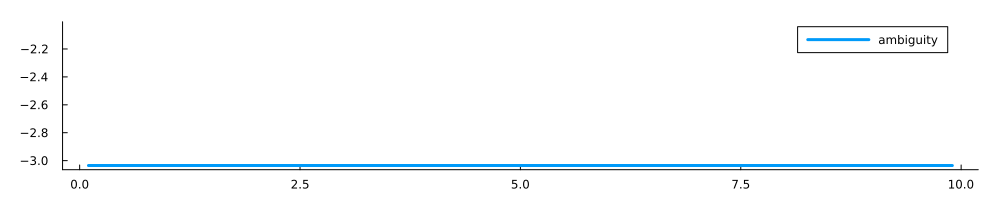

In [19]:
tix = 2:len_trial
plot(time[tix], cA[tix,end], label="ambiguity", size=(1000,200))
# plot!(time[tix], cR[tix,end], label="risk", linewidth=4, ylims=[-10,200])

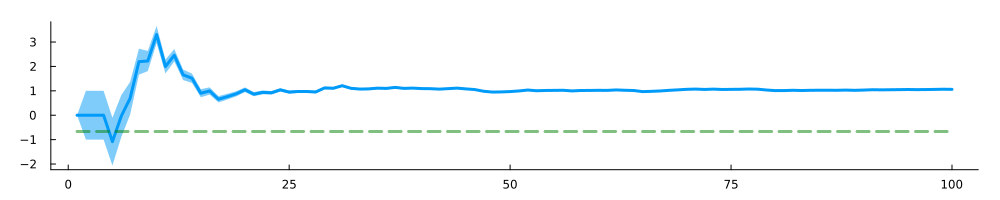

In [20]:
plot(θ_est[1], ribbon=sqrt.(θ_est[2]))
plot!(θ1_true*ones(len_trial), color="green", linestyle=:dash, alpha=0.5, size=(1000,200))